### Simulation

Even in the absence of an experimental setup, ``slmsuite`` is an ideal testbed for new holography algorithms and SLM techniques. Here, we demonstrate the basic simulation features of ``slmsuite`` to investigate the accuracy of the package's wavefront calibration routines.

In [1]:
# Header

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add slmsuite to the python path.
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography import toolbox
from slmsuite.holography import analysis
from slmsuite.holography.algorithms import Hologram
from slmsuite.holography.algorithms import SpotHologram

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('image', cmap='turbo')

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameraslms.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Simulated SLMs

`SimulatedSLM` is a testbed for implementing physical non-idealities of spatial light modulators, including panel curvature (near-field phase distortions), cross-talk/mutual coupling, and non-uniform control value-to-phase shift transduction across the aperture. 

We start by building a `SimulatedSLM` with an arbitary flatness map (using `slmsuite`'s [Zernike functions](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.phase.zernike_sum.html)) and elliptical source illumination.

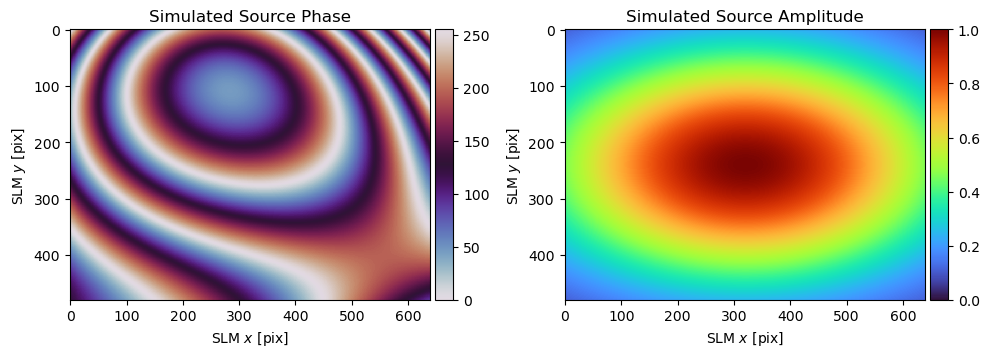

In [2]:
from slmsuite.hardware.slms.simulated import SimulatedSLM

# SLM resolution in pixels
res = (640,480)
bits = 8

#Build an arbitrary flatness map 
dummy_slm = SimulatedSLM(res)
phase_abberation = toolbox.phase.zernike_sum(dummy_slm,
    weights=(((2, 0),  7),       # Z_20
             ((2, 1), -8),       # Z_21
             ((3, 1),  9)),      # Z_31
    aperture="cropped")

# The abberated SLM
slm = SimulatedSLM(res, bitdepth=bits)
slm.set_source_analytic('gaussian2d', x0=0, y0=0, a=1, c=0, wx=0.4, wy=0.3, units="frac",
                         phase_offset = phase_abberation,
                         sim = True)
slm.plot_source(sim=True);

SimulatedSLM's (simulated) ``source`` attribute is independent of the SLM ``phase`` attribute, and is applied whenever ``phase`` is written to the SLM. We can therefore see the true phase profile of the SLM by plotting the ``display`` attribute.

#### Simulated Cameras

``SimulatedCam`` computes the far-field of ``SimulatedSLM`` with desired imaging transformations.

In [3]:
from slmsuite.hardware.cameras.simulated import SimulatedCam

# Option 1: demonstrate the full capability of the simulation mode.
# The simulated camera computes images projected by `slm` with the desired
# affine transformation and noise. Computing the intensity at each
# camera pixel therefore requires (slow) interpolation from the computed
# (and heavily padded) SLM far-field.
# Note that f_eff is in units pix/radian by default.
# Since the max steering angle is O(1 rad), f_eff~slm_res is a good proxy for unity magnification.

cam_res = (512,512)
cam_bits = 32 # Since camera precision typically limits convergence, we'll simulate a low-quanization-noise unit.
              # In practice, higher bit depth can be achieved by averaging multiple frames.
M, b = SimulatedCam.build_affine(f_eff=1.2*res[0], theta=np.pi/10)
readout_noise = {'read': lambda img: np.random.poisson(0.01*img)} # Support for readout noise & dark current
cam = SimulatedCam(slm, cam_res, M=M, b=b, bitdepth=cam_bits)

# Option 2: fastest simulation. 
# Directly sample the SLM far-field without transformations since the 
# "ij" and "knm" bases are equivalent.

# cam = SimulatedCam(slm)

Padded SLM k-space shape set to (1024,1024) to achieve required imaging resolution.


C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameras\simulated.py:159: UserWarning: Camera extends beyond the accessible SLM k-space; some pixels may not be targetable.
  warnings.warn(


Also note that since we created this simulated camera without specifying the effective focal length $f_\text{eff}$ between the SLM and camera, `slmsuite` computed the minimum effective focal length $f_\text{min}$ that places the camera fully within the SLM's accesible $k$-space. For more notes on $f_\text{eff}$ see the [`SimulatedCam` documentation](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.simulated.html). 

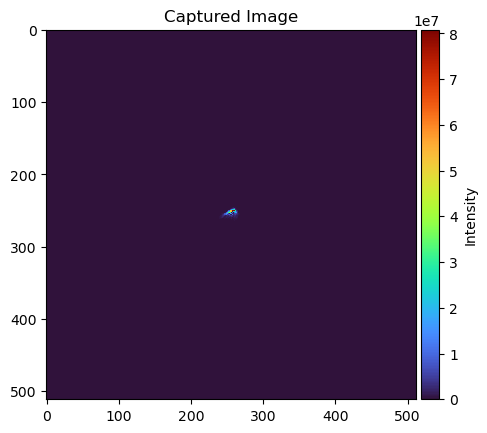

In [4]:
# Take a sample picture
im = cam.get_image(plot=True)

#### Using Simulation to Compare Wavefront Calibration Algorithms

Now that we have simulated SLM/camera pair, we can use ``slmsuite``'s features normally, as if we had an experiment in hand! Here, we'll use simulation mode to check the accuracy of various wavefront calibration techniques.

In [5]:
fs = FourierSLM(cam, slm)

  0%|          | 0/50 [00:00<?, ?it/s]

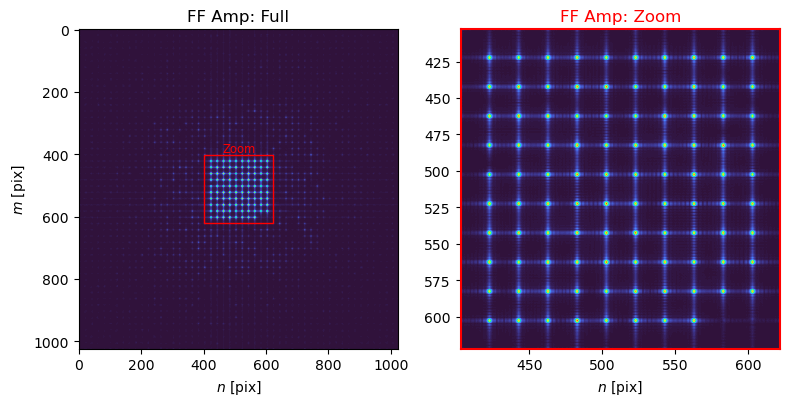

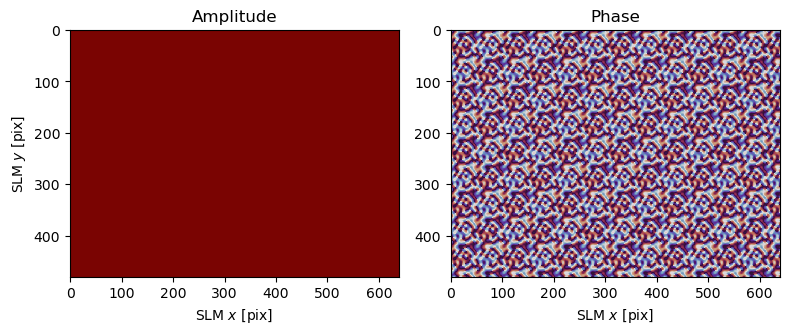

Reset exposure to 2.00s; maximum image value = 2716108.
Reset exposure to 4.00s; maximum image value = 5432216.
Reset exposure to 8.00s; maximum image value = 10864431.
Reset exposure to 16.00s; maximum image value = 21728862.
Reset exposure to 32.00s; maximum image value = 43457724.
Reset exposure to 64.00s; maximum image value = 86915448.
Reset exposure to 128.00s; maximum image value = 173830896.
Reset exposure to 256.00s; maximum image value = 347661792.
Reset exposure to 512.00s; maximum image value = 695323584.
Reset exposure to 1024.00s; maximum image value = 1390647168.
Reset exposure to 1581.29s; maximum image value = 2147483648.


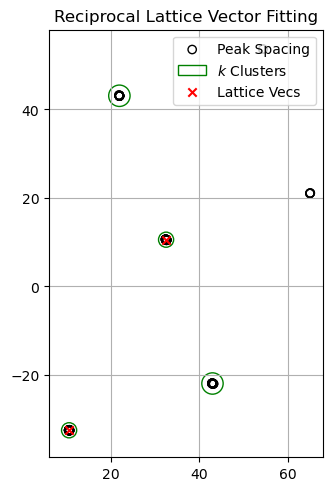

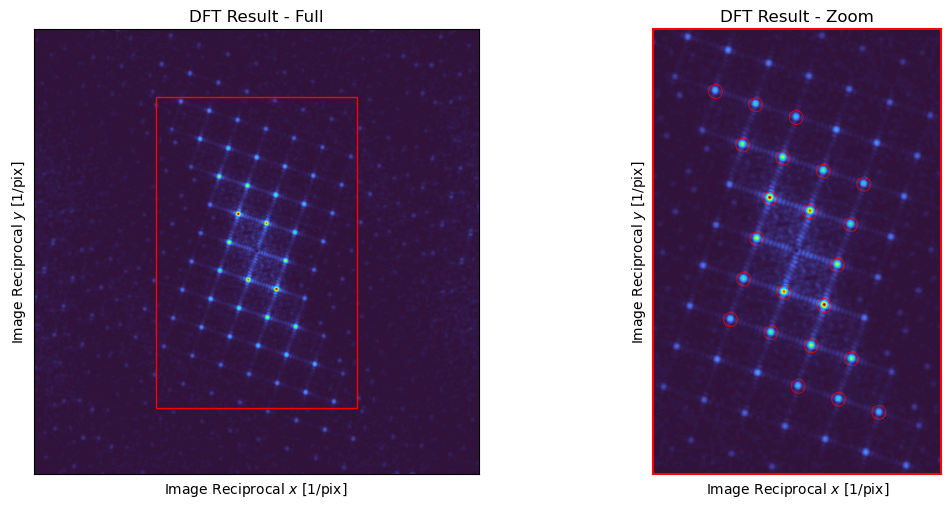

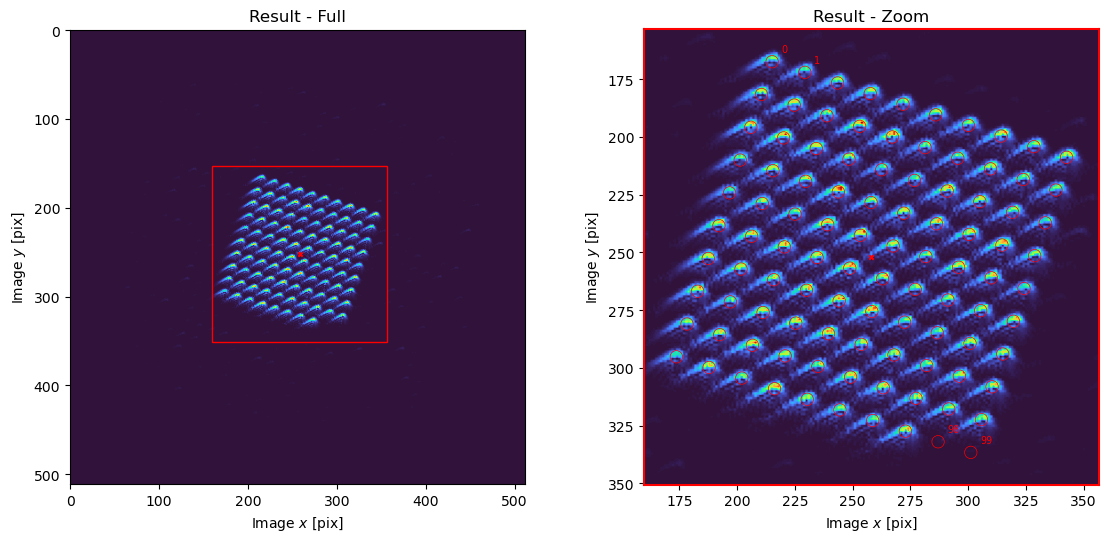

{'M': array([[ 725.2786387 , -235.86656908],
       [ 235.4082728 ,  726.89667526]]), 'b': array([[258.13495428],
       [252.02308401]]), 'a': array([[0.],
       [0.]])}


In [6]:
fs.fourier_calibrate(
    array_shape=[10, 10],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    autoexposure={"set_fraction":0.5},
    plot=True);
print(fs.fourier_calibration)

Once Fourier calibrated, we can wavefront calibrate. We'll use ``phase_steps=1`` first, which minimizes SLM writes by fitting the imaged 2D interference pattern between two superpixels. Let's test a superpixel...

Reset exposure to 3162.59s; maximum image value = 306618560.


C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameraslms.py:738: UserWarning: Non-resolvable interference fringe period for the given SLM calibration extent. Either exclude more of the SLM or magnify the field on the camera.
  warnings.warn(


Reset exposure to 6325.18s; maximum image value = 613237120.
Reset exposure to 12650.36s; maximum image value = 1226474240.
Reset exposure to 22150.03s; maximum image value = 2147483520.


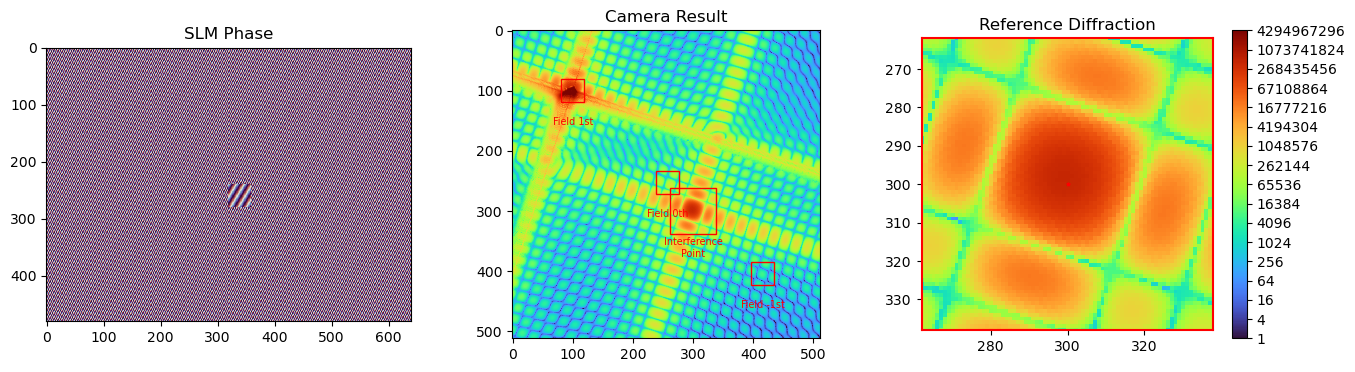

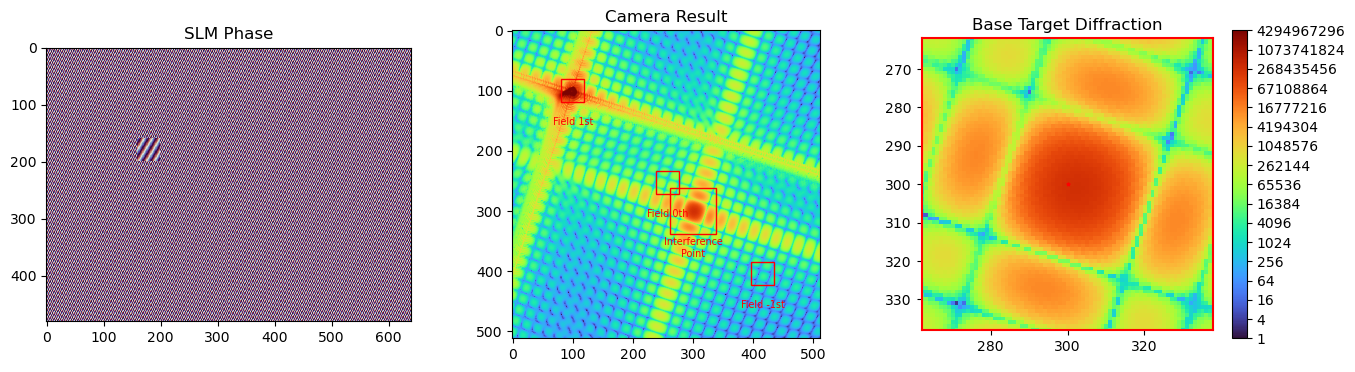

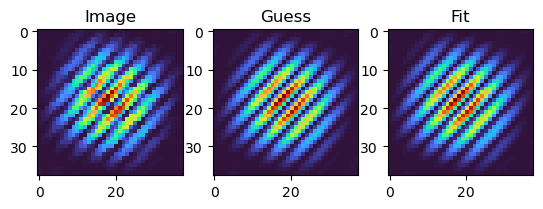

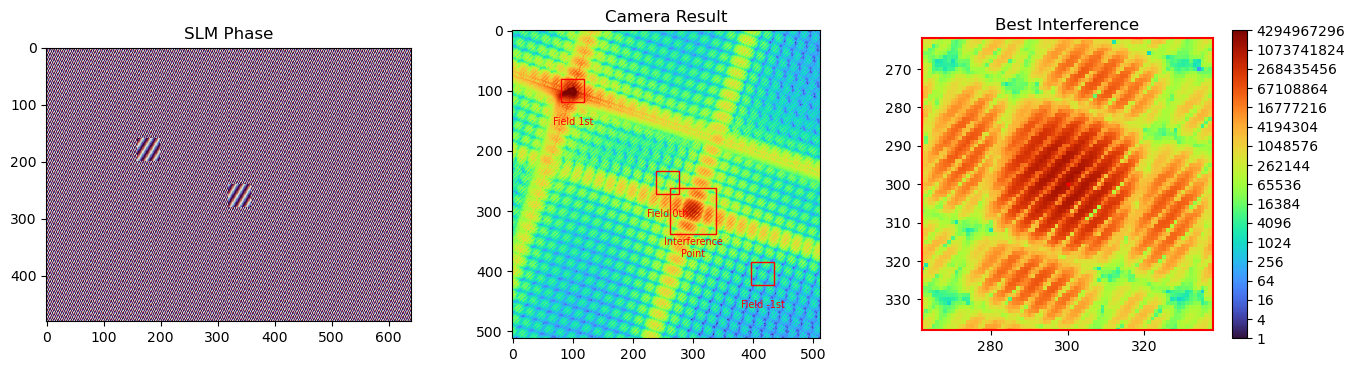

In [7]:
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(100, 100),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=1,
    test_superpixel=(4,4),
    plot=True,
    autoexposure=True);

Looks good -- let's calibrate!

In [8]:
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(100, 100),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=1,
    plot=False,
    autoexposure=True);

Reset exposure to 8860.01s; maximum image value = 858993408.
Reset exposure to 17720.02s; maximum image value = 1717986816.
Reset exposure to 22150.03s; maximum image value = 2147483520.


calibration:   0%|          | 0/192 [00:00<?, ?it/s]

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameraslms.py:1016: UserWarning: Image fitting failed; nulling response from this superpixel.
  warnings.warn("Image fitting failed; nulling response from this superpixel.")
C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameraslms.py:1022: RuntimeWarning: invalid value encountered in double_scalars
  contrast = np.abs(popt[1] / (np.abs(popt[1]) + np.abs(popt[3])))
C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\misc\fitfunctions.py:346: RuntimeWarning: divide by zero encountered in double_scalars
  return np.square(np.sinc((1 / R) * x) * np.sinc((1 / R) * y)) \
C:\Users\cpanu\anaconda3\lib\site-packages\numpy\lib\function_base.py:3477: RuntimeWarning: invalid value encountered in sin
  return sin(y)/y


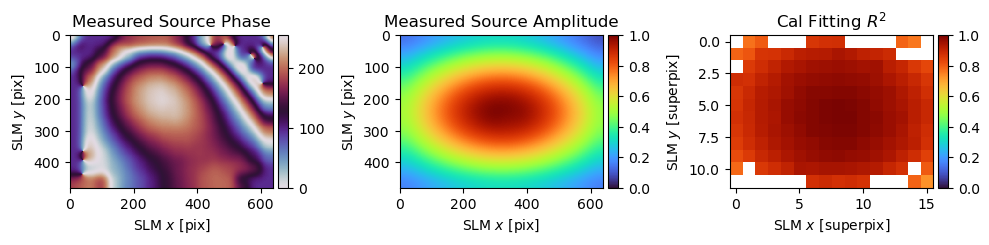

In [9]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True)

The phase pattern is smooth in the center but the fitting error increases around the panel edges where the illumination amplitude also drops off. The amplitude appears to be spot on (.. no pun intended ..). The real question is -- how does the computed flatness map compare to the true phase error?

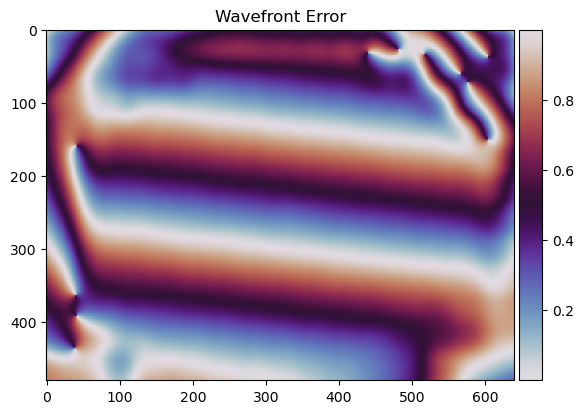

In [10]:
phase_corrected = np.mod(slm.source["phase"]+slm.source["phase_sim"], 2*np.pi)

fig, ax = plt.subplots(1,1)
im = ax.imshow(phase_corrected/(2*np.pi),
               cmap=plt.get_cmap("twilight"),
               interpolation="none")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Wavefront Error');

Qualitatively, we're (primarily) left with a residual blaze where the fitting was good. This makes sense, as any linear phase ramp in the true flatness map is effectively projected out (i.e. corrected) by **Fourier** calibration which calculates and compensates for the resulting spot translation. 

Quantiatively, how good did we do? To find out, let's try a hologram and compute some spot metrics.

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (480, 640) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


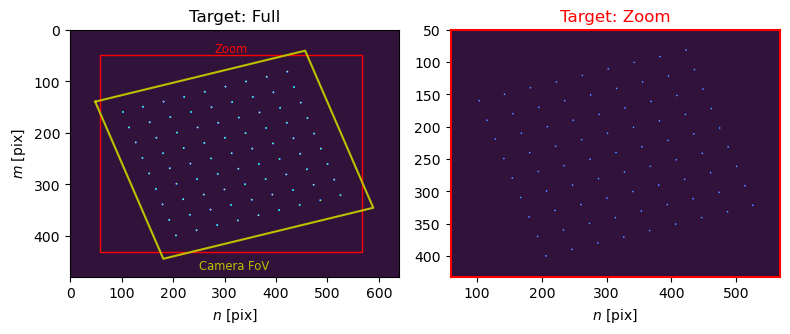

[array([ 59, 568], dtype=int64), array([ 50, 432], dtype=int64)]

In [11]:
# Make the desired hologram: a grid of points on the camera
xlist = np.arange(50, cam.shape[1]-50, 50)                    
ylist = np.arange(50,cam.shape[0]-50,50)
xgrid, ygrid = np.meshgrid(xlist, ylist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))

hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.plot_farfield(hologram.target, title="Target")

In [12]:
# Callback function: set camera exposure and center spots during first few WGS iterations
def tweaks(holo):
    if holo.iter == 0:
        cam.autoexposure(0.8)
    if holo.iter < 2:
        holo.refine_offset()
    return False

# Run WGS for 50 iterations; fix the far-field phase after 10 iterations
hologram.optimize(
    'WGS-Kim',
    maxiter=50,
    callback = tweaks,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

  0%|          | 0/50 [00:00<?, ?it/s]

Reset exposure to 2215.00s; maximum image value = 4294967296.
Reset exposure to 1107.50s; maximum image value = 4294967296.
Reset exposure to 553.75s; maximum image value = 4294967296.
Reset exposure to 276.88s; maximum image value = 4294967296.
Reset exposure to 138.44s; maximum image value = 4294967296.
Reset exposure to 69.22s; maximum image value = 4294967296.
Reset exposure to 34.61s; maximum image value = 2771572480.
Reset exposure to 26.82s; maximum image value = 2147483648.


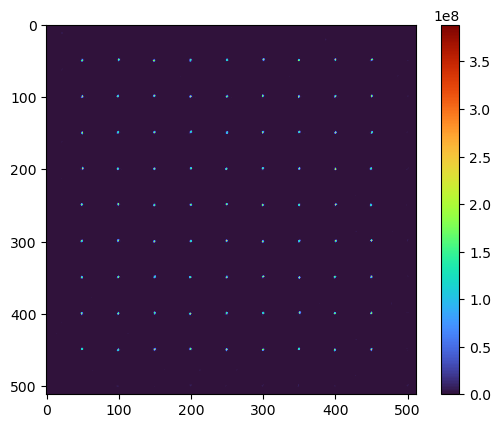

In [13]:
plt.imshow(cam.get_image())
plt.colorbar()

Now let's visualize the results and calculate a few statistics for comparison.

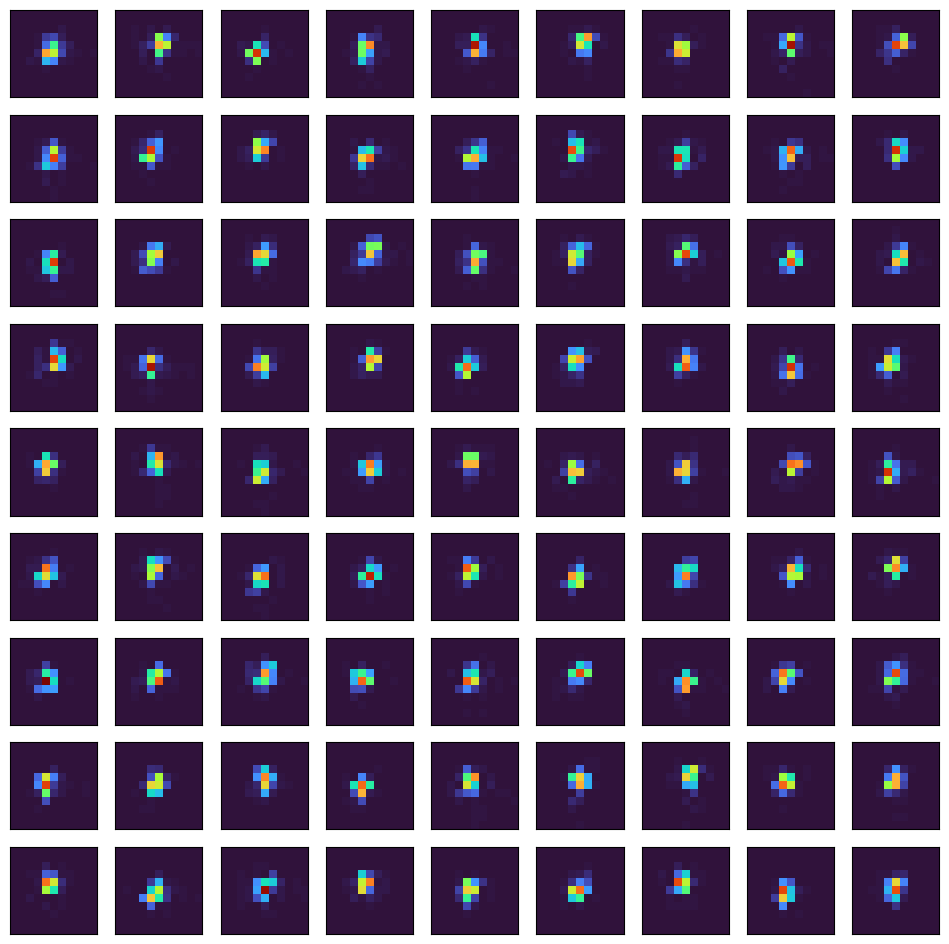

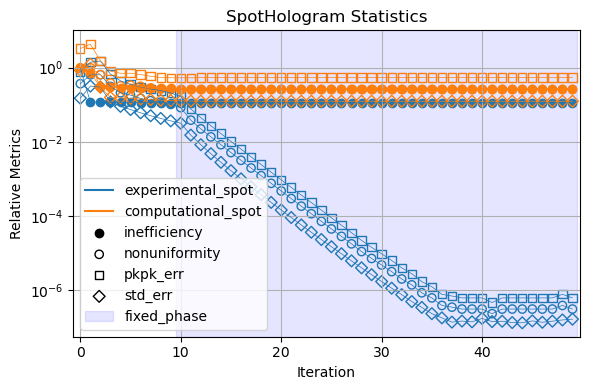

Spot center = (-0.305,-0.420) +/- (0.156,0.187) px
Spot skew = 0.010 +/- 0.272 px


In [14]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, hologram.spot_integration_width_ij)
analysis.take_plot(subimages)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
# plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Peak-to-peak power uniformity bottoms out ~$10^{-6}$. Lets compare the other stats to those generated using: 1) wavefront calibration using ``phase_steps>1``; and 2) perfect wavefront calibration.

In [15]:
#1) phase_steps=10
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(800, 500),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=10,
    plot=False,
    autoexposure=True);

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameraslms.py:738: UserWarning: Non-resolvable interference fringe period for the given SLM calibration extent. Either exclude more of the SLM or magnify the field on the camera.
  warnings.warn(


Reset exposure to 85.81s; maximum image value = 8323216.
Reset exposure to 171.62s; maximum image value = 16646432.
Reset exposure to 343.25s; maximum image value = 33292864.
Reset exposure to 686.50s; maximum image value = 66585728.
Reset exposure to 1372.99s; maximum image value = 133171456.
Reset exposure to 2745.98s; maximum image value = 266342912.
Reset exposure to 5491.97s; maximum image value = 532685824.
Reset exposure to 10983.93s; maximum image value = 1065371648.
Reset exposure to 21967.87s; maximum image value = 2130743296.


calibration:   0%|          | 0/192 [00:00<?, ?it/s]

superpixel=(0,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,11):   0%|          | 0/10 [00:00<?, ?it/s]

The calibration took ~2x longer (and with ~10x more calls to the SLM, which would actually dominate calibration time in an experiment); how did it perform?

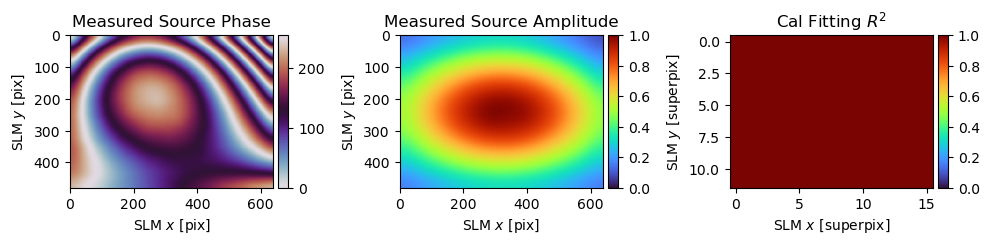

In [16]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True)

So the result is cleaner, but does better fitting mean better spots? Let's see...

In [17]:
#Redo Fourier cal
fs.fourier_calibrate(
    array_shape=[10, 10],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

{'M': array([[ 728.7334755 , -236.55178773],
        [ 236.5546728 ,  729.12798521]]),
 'b': array([[258.07648378],
        [251.78118044]]),
 'a': array([[0.],
        [0.]])}

In [18]:
hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.optimize(
    'WGS-Kim',
    maxiter=50,
    callback = tweaks,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (480, 640) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Reset exposure to 2196.79s; maximum image value = 4294967296.
Reset exposure to 1098.39s; maximum image value = 4294967296.
Reset exposure to 549.20s; maximum image value = 4294967296.
Reset exposure to 274.60s; maximum image value = 3987661312.
Reset exposure to 147.88s; maximum image value = 2147483520.


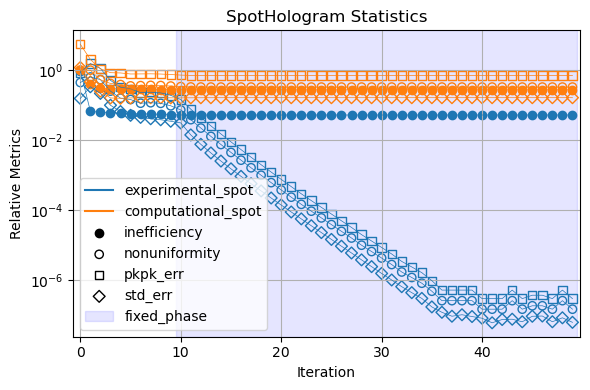

Spot center = (0.006,-0.065) +/- (0.118,0.235) px
Spot skew = -0.058 +/- 0.167 px


In [19]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, hologram.spot_integration_width_ij)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
# plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

The spot centering improved significantly and skew is a *bit* better. How about perfect wavefront calibration?

In [20]:
# Perfect calibration: set measured to simulated values
slm.source["phase"] = -slm.source["phase_sim"]
slm.source["amplitude"] = slm.source["amplitude_sim"]

In [21]:
#Redo Fourier cal
fs.fourier_calibrate(
    array_shape=[10, 10],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

{'M': array([[ 729.36511487, -236.55879918],
        [ 236.20503077,  729.520177  ]]),
 'b': array([[255.49978126],
        [255.50111415]]),
 'a': array([[0.],
        [0.]])}

In [22]:
hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.optimize(
    'WGS-Kim',
    maxiter=50,
    callback = tweaks,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (480, 640) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Reset exposure to 127.35s; maximum image value = 2147483648.


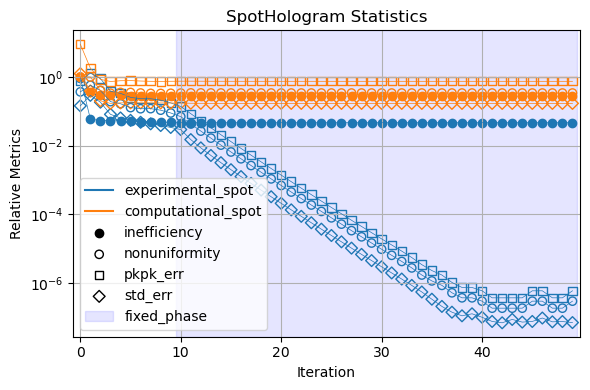

Spot center = (-0.015,-0.027) +/- (0.124,0.188) px
Spot skew = -0.054 +/- 0.178 px


In [23]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, hologram.spot_integration_width_ij)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
# plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Not much different. So both wavefront calibration routines work well (the single point calibration can also be improved by reducing the lower bound for acceptable values of $R^2$ fitting quality). As we continue to develop `slmsuite`, we plan to introduce additional wavefront calibration routines along with better metrics (e.g., Strehl ratio) to study their performance. 

#### Cloning an Experiment into Simulation